In [1]:
import numpy as np
import pandas as pd
import itertools
import random
import warnings

from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, report_fit
import matplotlib.pyplot as plt

In [2]:
#Global parameters
tstart = 0; tfinal = 100 #initial and final time points
dose = 3410 #mg to nmol

#Load data
PATH_TO_DATA='../../../Data/Matthews2017/Digitized/PK/'
data_05mg = pd.read_csv(PATH_TO_DATA+'05mg.csv')
data_1mg = pd.read_csv(PATH_TO_DATA+'1mg.csv')
data_2mg = pd.read_csv(PATH_TO_DATA+'2mg.csv')
data_10mg = pd.read_csv(PATH_TO_DATA+'10mg.csv')
data_30mg = pd.read_csv(PATH_TO_DATA+'30mg.csv')

data_05mg = data_05mg.dropna(axis='columns')
data_1mg = data_1mg.dropna(axis='columns')
data_2mg = data_2mg.dropna(axis='columns')
data_10mg = data_10mg.dropna(axis='columns')
data_30mg = data_30mg.dropna(axis='columns')

data_05mg.columns = ['time','conc']
data_1mg.columns = ['time','conc']
data_2mg.columns = ['time','conc']
data_10mg.columns = ['time','conc']
data_30mg.columns = ['time','conc']

datalist = [data_10mg, data_30mg, data_2mg, data_1mg, data_05mg]
data = pd.concat([data_10mg, data_30mg, data_2mg, data_1mg, data_05mg]) #assembled data

z0 = [[10*dose,0,0],[30*dose, 0, 0],[2*dose,0,0], [dose,0,0], [0.5*dose,0,0]]

t_observed = data.time.tolist(); z_observed = data.conc.tolist()

In [3]:
#compartment Model
def two_comp_model(t, z, params):
    #parameters to estimate
    ka = params['ka'].value
    Vc = params['Vc'].value
    k10 = params['k10'].value
    k12 = params['k12'].value
    k21 = params['k21'].value
    #dose, central and peripheral compartment
    Z0 = z[0]; Z1 = z[1]; Z2 = z[2]
    dZ0 = -ka*Z0
    dZ1 = (ka/Vc)*Z0 - k10*Z1 - k12*Z1 + k21*Z2
    dZ2 = k12*Z1 - k21*Z2
    d = [dZ0,dZ1,dZ2]
    return d

def solve_ode(z, data_mat, params):
    '''
    Solve the ODE-system for
    z = initial state of the system
    data_mat = assembled data set
    params = parameters to estimate
    
    return list of drug concentrations from plasma compartment (Z1)
    '''
    logZ1=[]
    ind = data_mat.index.tolist() #get indices
    offset=0 #each data set is continuously numbered
    for j in range(len(z)):
        i=0
        while (ind[i+offset] == i): #while index euqlas offset
            i+=1
            if i+offset > len(ind)-1: #break if end of list is reached
                break
        offset+=i #add current index to offset
        t_obs = data_mat.time[offset-i:offset].tolist()
        res = solve_ivp(two_comp_model, (tstart,tfinal), z[j], t_eval=t_obs,args=(params,))
        logZ1.append(np.log10(res.y[1])) #plasma compartment
    return list(itertools.chain.from_iterable(logZ1))

def solve_ode_simple(z, t_obs, params): #solve ode for a single data set
    res = solve_ivp(two_comp_model, (tstart,tfinal), z, t_eval=t_obs,args=(params,))
    return res

def residual(params, z, data_mat):
    logZ1 = solve_ode(z, data_mat, params)
    return np.power(np.subtract(logZ1, data.conc.tolist()),2)

In [ ]:
#Find parameter boundaries
warnings.filterwarnings('ignore')

#initial upper boundaries
va_max = 500
vc_max = 1000
v10_max = 500
v12_max = 500
v21_max = 500

threshold = 100 #user-defined, empirically determined
count = 0; maxcount = 20 #initial and maximal number of successful iterations

#datastructures to store the results
kalist = []; k10list = []; k12list = []; k21list = []; Vclist = []
rsslist = []


while count < maxcount:
    #draw random numbers
    va = random.uniform(0,va_max)
    v10 = random.uniform(0,v10_max)
    v12 = random.uniform(0,v12_max)
    v21 = random.uniform(0,v21_max)
    vc = random.uniform(0,vc_max)
    if va < v10: va = v10+random.uniform(0,10)
    if v12 < v21: v12 = v21+random.uniform(0,1)
    #add to object parameters
    parameters = Parameters()
    parameters.add('ka', value = va, min = 0, max = va_max)
    parameters.add('k10', value = v10, min = 0, max = v10_max)
    parameters.add('k12', value = v12, min = 0, max = v12_max)
    parameters.add('k21', value = v21, min = 0, max = v21_max)
    parameters.add('Vc', value = vc, min = 0, max = vc_max)
    #print('Parameters ')
    #print('ka ', va)
    #print('k10 ', v10)
    #print('k12 ', v12)
    #print('k21 ', v21)
    #print('Vc ', vc)
    #print()

    success = True
    while success:
        log_Z1 = solve_ode(z0 , data, parameters)

        if (np.isnan(log_Z1).any() == True or np.isinf(log_Z1).any() == True): 
            print('errors in computed concentrations')
            print()
            #if any error then resample parameters by shrinking to smaller values
            va = random.uniform(0,parameters['ka'].value)
            v10 = random.uniform(0,parameters['k10'].value)
            v12 = random.uniform(0,parameters['k12'].value)
            v21 = random.uniform(0,parameters['k21'].value)
            vc = random.uniform(0,parameters['Vc'].value)
            if va < v10: va = v10+random.uniform(0,5)
            if v12 < v21: v12 = v21+random.uniform(0,1)
            parameters = Parameters()
            parameters.add('ka', value = va, min = 0, max = va+0.1)
            parameters.add('k10', value = v10, min = 0, max = v10+0.1)
            parameters.add('k12', value = v12, min = 0, max = v12+0.1)
            parameters.add('k21', value = v21, min = 0, max = v21+0.1)
            parameters.add('Vc', value = vc, min = 0, max = vc+0.1)
            #print('New Parameters ')
            #print('ka ', va)
            #print('k10 ', v10)
            #print('k12 ', v12)
            #print('k21 ', v21)
            #print('Vc ', vc)
            #print()

        else:
            rss = np.sum(residual(parameters, z0, data))
            print('RSS = ', rss)
            if (rss < threshold): 
                kalist.append(parameters['ka'].value)
                k10list.append(parameters['k10'].value)
                k12list.append(parameters['k12'].value)
                k21list.append(parameters['k21'].value)
                Vclist.append(parameters['Vc'].value)
                rsslist.append(rss)
                count += 1
                print(); print('number of the run ',count)
                print()
                success = False
            else:
                success = False
                print('RSS too large.')
                print()

In [5]:
#Evaluation
dfresult = pd.DataFrame(list(zip(rsslist,kalist,k10list,k12list,k21list,Vclist)), 
                        columns =['RSS', 'ka', 'k10', 'k12', 'k21', 'Vc'])

dfres = dfresult.sort_values(by=['RSS']) #sort dataframe by RSS values
#dfres.to_excel('plasmaboundaries_it100.xlsx') #store results
print(dfres)

print('\n Mean values')
print('ka ' , np.mean(dfres['ka']))
print('k10 ' , np.mean(dfres['k10']))
print('k12 ' , np.mean(dfres['k12']))
print('k21 ' , np.mean(dfres['k21']))
print('Vc ' , np.mean(dfres['Vc']))
print('\n Max. values')
print('ka ' , np.max(dfres['ka']))
print('k10 ' , np.max(dfres['k10']))
print('k12 ' , np.max(dfres['k12']))
print('k21 ' , np.max(dfres['k21']))
print('Vc ' , np.max(dfres['Vc']))

          RSS          ka        k10         k12        k21          Vc
9    8.830732   13.235307  12.357108   24.746554   0.138278    1.154367
11   9.089653   22.202582  12.519996    1.008206   0.072781    0.171668
17  10.131753    6.707551   0.659204  229.571096  19.763356   29.200257
19  12.878081   71.363505   0.258668   37.944626  16.795069   90.871769
6   21.315980    7.596504   2.592335    1.948184   0.123495   31.506446
15  28.492875    9.152184   0.558413    4.195523   1.088021   19.133686
8   31.983282    3.760510   0.105638    6.630650   6.423528   53.002396
13  39.319966   95.611490   5.270968    6.645397   0.235960   16.289535
18  40.559346   81.341926   0.254060   15.395355   3.293980   15.626673
10  41.592042   21.571858   1.201290   45.038237   3.992677    3.674202
7   44.254325   82.586959   0.012880  112.648461   3.557978    8.129044
16  48.959662    5.462059   3.877929   13.812677   0.115334    0.560188
1   50.187999  169.084527   1.003457    3.664782   0.617320  105

In [ ]:
#set found boundaries to randomly sample from the parameter space
def new_params():
    global parameters
    va = random.uniform(0,100)
    v10 = random.uniform(0,1)
    v12 = random.uniform(0,1)
    v21 = random.uniform(0,1)
    vc = random.uniform(0,300)
    #constraints
    if va < v10: va = v10+random.uniform(0,1)
    if v12 < v21: v12 = v21+random.uniform(0,1)
    if v12 < v10: v12 = v12+random.uniform(0,1)
    parameters = Parameters()
    parameters.add('ka', value = va, min = 0, max = 100)
    parameters.add('k10', value = v10, min = 0, max = 1)
    parameters.add('k12', value = v12, min = 0, max = 1)
    parameters.add('k21', value = v21, min = 0, max = 1)
    parameters.add('Vc', value = vc, min = 0, max = 300)
    #print('Parameters ')
    #print('ka ', va)
    #print('k10 ', v10)
    #print('k12 ', v12)
    #print('k21 ', v21)
    #print('Vc ', vc)
    #print()

#Parameter optimization
warnings.filterwarnings('ignore')

threshold = -200 #user-defined, empirically determined
count = 0; maxcount = 10 #set number of successful runs

kaList = []; k10List = []; k12List = []; k21List = []; VcList = []
aicList = []; rssList = []

while count < maxcount:
    new_params() #sample parameters
    try:
        result = minimize(residual, parameters, args=(z0, data), method = 'leastsq') #Levenberg-Marquardt algorithm
        #report_fit(result) #print results of minimizer
        print('count = ',count,' AIC = ',result.aic)
        if result.aic < threshold: #if resulting AC smaller than the threshold store the parameters
            kaList.append(result.params['ka'].value)
            k10List.append(result.params['k10'].value)
            k12List.append(result.params['k12'].value)
            k21List.append(result.params['k21'].value)
            VcList.append(result.params['Vc'].value)
            aicList.append(result.aic)
            rssList.append(np.sum(result.residual))
            #print('RSS = ', np.sum(result.residual))
            count += 1
            print(); print('number of the run ',count)
            print()
        else:
            print('AIC too large')
            print()
    except:
        print('count = ',count)
        print('an unexpected error occurred!')
        print()

In [7]:
#Evaluation
dfResult = pd.DataFrame(list(zip(rssList,aicList,kaList,k10List,k12List,k21List,VcList)),
                        columns =['RSS', 'AIC', 'ka', 'k10', 'k12', 'k21', 'Vc'])

df_res = dfResult.sort_values(by=['RSS']) #sort by RSS value
print(); print(df_res)

print()
indmin = np.argmin(aicList)
print('minimales AIC = ',aicList[indmin])
print('ka = ',kaList[indmin]) 
print('k10 = ',k10List[indmin]) 
print('k12 = ',k12List[indmin]) 
print('k21 = ',k21List[indmin]) 
print('Vc = ',VcList[indmin])
print()
print('mean values')
print('ka mean = ',np.mean(kaList))
print('k10 mean = ',np.mean(k10List))
print('k12 mean = ',np.mean(k12List))
print('k21 mean = ',np.mean(k21List)) 
print('Vc mean = ',np.mean(VcList))
print()
print('ka min = ',np.min(kaList))
print('k10 min = ',np.min(k10List))
print('k12 min = ',np.min(k12List))
print('k21 min = ',np.min(k21List)) 
print('Vc min = ',np.min(VcList))
print()
print('ka max = ',np.max(kaList))
print('k10 max = ',np.max(k10List))
print('k12 max = ',np.max(k12List))
print('k21 max = ',np.max(k21List)) 
print('Vc max = ',np.max(VcList))
print()
print('Devaitions: ')
print('ka std = ',np.std(kaList))
print('k10 std = ',np.std(k10List))
print('k12 std = ',np.std(k12List))
print('k21 std = ',np.std(k21List)) 
print('Vc std = ',np.std(VcList))


#df_res.to_excel('plasmaoptimization_it250.xlsx') #store results


        RSS         AIC         ka       k10       k12       k21          Vc
0  0.250894 -289.670972  64.002053  0.236152  0.174285  0.025840  161.600430
7  0.250929 -289.670967  18.005507  0.234521  0.175816  0.026030  164.278013
6  0.250935 -289.671001  83.833242  0.236336  0.174186  0.025828  161.330861
5  0.250936 -289.670999  21.678717  0.234915  0.175464  0.025986  163.634448
3  0.250942 -289.670997  20.858105  0.234839  0.175533  0.025995  163.758704
9  0.250944 -289.671000  27.202284  0.235310  0.175116  0.025942  162.994028
4  0.254522 -289.317170  18.351978  0.239602  0.181111  0.026649  159.802690
8  0.258718 -289.200144  10.587694  0.233372  0.176593  0.025226  166.872954
2  0.265989 -288.520601   7.738496  0.238274  0.186666  0.027069  164.806036
1  0.555444 -225.201723   6.012784  0.148505  0.119176  0.024072  295.668568

minimales AIC =  -289.6710006407463
ka =  83.833241915967
k10 =  0.23633622928048492
k12 =  0.174185665624649
k21 =  0.02582821659066531
Vc =  161.3308

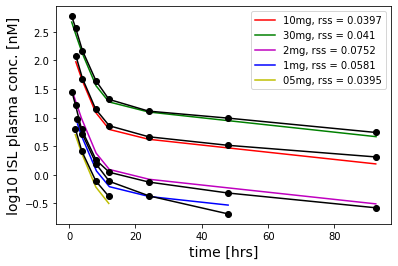

In [15]:
#plot fitted on clinical data

#estimated parameters
va = 45.4382
v10 =  0.2355
v12 =  0.175
v21 =  0.0259
vc =  162.69

parameters = Parameters()
parameters.add('ka', value=va, vary=False)
parameters.add('k10', value=v10, vary=False)
parameters.add('k12', value=v12, vary=False)
parameters.add('k21', value=v21, vary=False)
parameters.add('Vc', value=vc, vary=False)

l = ['10mg', '30mg', '2mg', '1mg', '05mg'] #label
c = ['r-', 'g-', 'm-', 'b-', 'y-'] #color

i=0
for d in datalist:
    res = solve_ode_simple(z0[i], d.time.tolist(), parameters)
    log_Z1 = np.log10(res.y[1])
    rss = np.sum(np.power(np.subtract(log_Z1, d.conc.tolist()),2)) #residual sum of squares
    plt.plot(d.time.tolist(), log_Z1, c[i], label=l[i]+', rss = '+str(round(rss,4)))
    plt.plot(d.time.tolist(), d.conc.tolist(), 'ko-')
    i+=1
#plt.title('Plasma PK versus Time')
plt.ylabel('log10 ISL plasma conc. [nM]', fontsize=14)
plt.xlabel('time [hrs]', fontsize=14)
plt.legend()
plt.show()